In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
!ls -l /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/

total 41853344
-rw-rw-r--+ 1 mabi3848 hpc-users  120392345 Jul 11 15:18 apo_conc_gly_50_2_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users      23079 Jun 28 14:11 background_0003.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1161373434 Jul 11 15:35 ferritin_conc100_gly_50_1_0002.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  703980477 Jul 11 15:39 ferritin_conc100_gly_50_1_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2330393309 Jul 11 15:54 ferritin_conc100_gly_50_1_0009.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1144299172 Jul 11 15:43 ferritin_conc100_gly_50_1_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2461504414 Jul 11 16:12 ferritin_conc100_gly_50_1_0012.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2539875762 Jul  5 17:15 ferritin_conc100_gly_50_1_0013.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1604681690 Jul  5 17:06 ferritin_conc100_gly_50_1_0014.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  745507304 Jul 13 15:11 ferritin_conc100_gly_50_2_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  527515584 Jul 13 11:03 ferritin_conc100_gly_50_2_0011.h5
-rw-rw-

In [26]:
# c1 temps 250-210 K full beam
# runnames = ['ferritin_conc_gly_50_6']
# datasetnumbers = [2,3,4,5,6]

# # c2
# runnames = ['ferritin_conc100_gly_50_1', 'ferritin_conc100_gly_50_1', 'ferritin_conc100_gly_50_1', 'ferritin_conc100_gly_50_1']
# datasetnumbers = [12,6,9]

# # c3 temps 250-220 K full beam
runnames = ['ferritin_conc120_gly_50_1']
datasetnumbers = [4,5,7,8]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc120_gly_50_1',
 'ferritin_conc120_gly_50_1',
 'ferritin_conc120_gly_50_1',
 'ferritin_conc120_gly_50_1']

In [27]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0004.h5 
File exists:  True 

measurement folder   ferritin_conc120_gly_50_1_0004
Temperature, K       260.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs_mesh 4 reps
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0005.h5 
File exists:  True 

measurement folder   ferritin_conc120_gly_50_1_0005
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs_mesh 4 reps
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 
File exists:  True 

measurement folder   ferritin_conc120_gly_50_1_0007
Temperature, K       240.0
tra

# Plot g2s

In [28]:
def exponential(x, beta, tau):
    return np.abs(beta) * np.exp( -2*x/(np.abs(tau)) )

def exponential_kww(x, beta, tau, kww):
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww )

def linear(x, m):
    return m*x

In [29]:
# with h5py.File( h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5', 'r') as f: 
#     f.visititems(visit_func)

In [30]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
print(np.shape(g2s))

(4, 12, 80)


In [31]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')
eta_50 = eta_50v_gly()
eta_60 = eta_60v_gly()
beta_vs_q

array([0.15964507, 0.15949404, 0.15918963, 0.1587956 , 0.15834509,
       0.1576657 , 0.15686018, 0.15597819, 0.15482857, 0.15376757,
       0.15292362, 0.15141127])

### With kww=1

260 36021.59116048972 2632.502194165584
250 13702.450792313568 527.9890088855001
240 5888.49066277895 193.47195031876527
230 2223.6729186525986 90.11710837132941


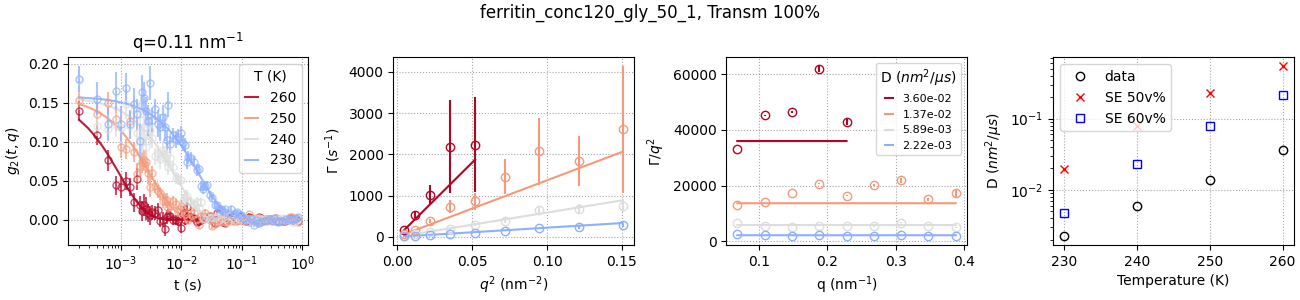

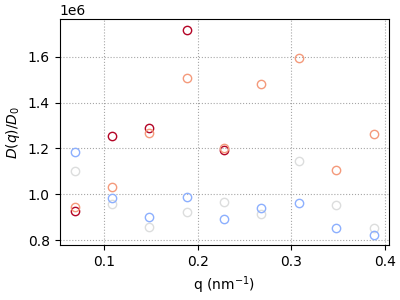

In [32]:
f, (a1,a3,a4,a2) = plt.subplots(1,4, figsize=(13,3), constrained_layout=True)
f2, a5 = plt.subplots(1,1, figsize=(4,3), constrained_layout=True)

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)+1))
qv_sel = 2
tol = 1e-3

qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            # a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{T[i][:-2]}')#({datasetnumbers[i]})') 
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)

    cond = (taus>dtaus) & (dtaus!=0)
    # print(T[i][:-2], qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2))
    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    print(T[i][:-2],  popt[0], perr[0])

    # update diffusion coefficient table
    # update_D_coeff(T=int(T[i][:-2]), Tr=f'{Tr[i]}%', D=popt[0]*1e-6, dD=perr[0]*1e-6, c='c2')

    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a4.plot(np.sqrt(xc), curve/xc, c=col[i], label=f'{Ds[0,i]:.2e}')
    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    a4.errorbar(qs[cond], 1/taus[cond]/qs[cond]**2, dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a2.plot(int(T[i][:-2]), Ds[0,i], ls='', marker='o', mfc='none', c='k')
    a2.plot(int(T[i][:-2]), D_coeff(T=int(T[i][:-2]), eta=eta_50[int(T[i][:-2])]) , ls='', marker='x', mfc='none', c='r')
    a2.plot(int(T[i][:-2]), D_coeff(T=int(T[i][:-2]), eta=eta_60[int(T[i][:-2])]) , ls='', marker='s', mfc='none', c='b')

    a5.plot(qs[cond], 1/taus[cond]/qs[cond]**2/Ds[0,i], c=col[i], ls='', marker='o', mfc='none')

a1.legend(title=r'T (K)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_title(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$")
f.suptitle(f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
# a3.set_ylim(0,1e4)
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma/q^2$')
a2.set_xlabel('Temperature (K)')
a2.set_ylabel('D (${{nm}}^{{2}}$/${{\mu s}}$)')
a2.set_yscale('log')
a4.legend(title='D (${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.8, bbox_to_anchor=[1,1])
a2.legend(['data', 'SE 50v%', 'SE 60v%'], fontsize=10)
a5.set_xlabel(r'q (nm$^{-1}$)')
a5.set_ylabel(r'$D(q)/D_0$');

In [12]:
df = pd.read_pickle('../03-source/diffusion_coefficient')
df[df['c']=='c2']

,temperature,transmission,D,dD,c
18,250,100%,0.047516,0.003283,c2
19,240,nan%,0.015848,0.000249,c2
20,260,100%,0.121895,0.002851,c2


In [15]:
# plt.figure(figsize=(4,3))
# cond1 = df[(df['temperature']==240) & ((df['transmission']=='100%') | (df['transmission']=='nan%'))].sort_values(by='c')
# # cond1
# plt.errorbar(cond1['c'], cond1['D'], cond1['dD'], ls='', marker='o', ms=5)
# plt.ylabel('Diffusion coefficient ($nm^2/\mu s$)')
# plt.xlabel('concentration')
# plt.tight_layout()

In [16]:
# dff = df.drop([14,15,16,17])
# dff.to_pickle('../03-source/diffusion_coefficient')

In [17]:
!ls ../03-source/

backgrounds.npz        ferritin_conc_gly_50_4_0002_0002_scan0001_g2.npy
contrast_vs_q2.npy     ferritin_conc_gly_50_4_0002_scan0001_avg_g2.npy
contrast_vs_q.npy      Iqs_apo_conc_gly_50_2_0006.npz
diffusion_coefficient  water_gly_50_0002_scan0001_avg.npy
elog		       water_gly_50_0002_scan0001.npy


### Free kww

/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.0, 3.0)

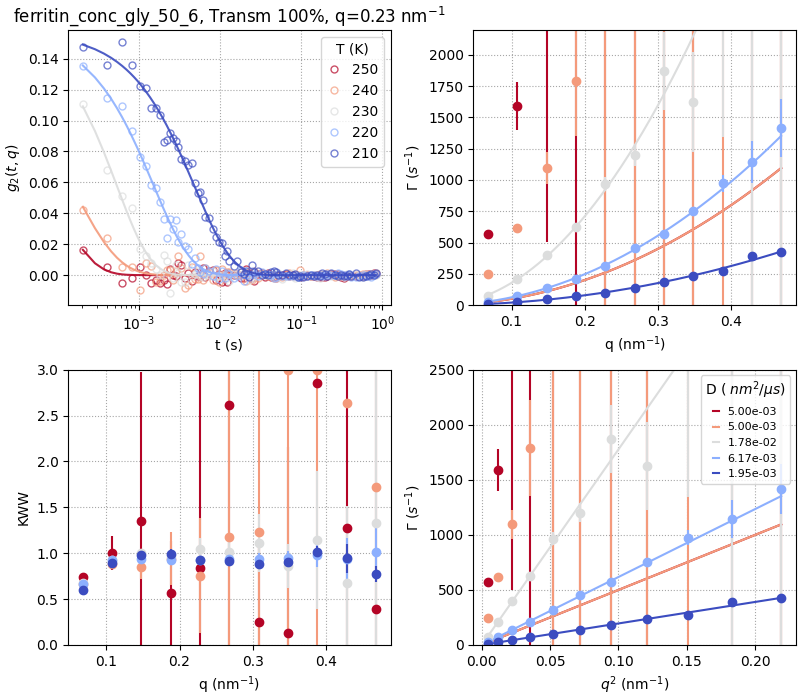

In [18]:
f, ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(8,7), constrained_layout=True)

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))

qv_sel = 5
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv), 1

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    kww, dkww = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential_kww, delay, g2s[i,q,:]-base, p0=[beta_vs_q[q],5e-2,1.], 
                                 bounds=[(beta_vs_q[q]-tol,0,0),(beta_vs_q[q]+tol,np.infty,3)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        kww.append(popt[2])
        dkww.append(perr[2])
        
        if q==qv_sel:
            a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7, label=f'{T[i][:-2]}')# ({datasetnumbers[i]})')
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9)#, label=f'{qv[q]:.2f}')
        
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    kww, dkww = np.asarray(kww), np.asarray(dkww)

    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max:qstep]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])

    a2.plot(np.sqrt(xc), curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a2.errorbar(qv[qv_min:qv_max:qstep], 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a4.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a4.errorbar(qv[qv_min:qv_max:qstep]**2, 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a3.errorbar(qv[qv_min:qv_max:qstep], kww, dkww, c=col[i], ls='', marker='o', label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')

a1.set_title(f"{runname}, Transm {Tr[i]}%, q={qv[qv_sel]:.2f} nm$^{{-1}}$")
a1.legend(title=r'T (K)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a4.legend(title=r'D ( ${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.5)
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a2.set_xlabel(r'q (nm$^{-1}$)')
a2.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a2.set_ylim(0,2200)
a4.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_ylim(0,2500)
a3.set_xlabel(r'q (nm$^{-1}$)')
a3.set_ylabel('KWW')
a3.set_ylim(0,3)

### Free contrast, kww=1

In [44]:
def exponential_beta(x, beta, tau):
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau))) )

/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.0, 0.2)

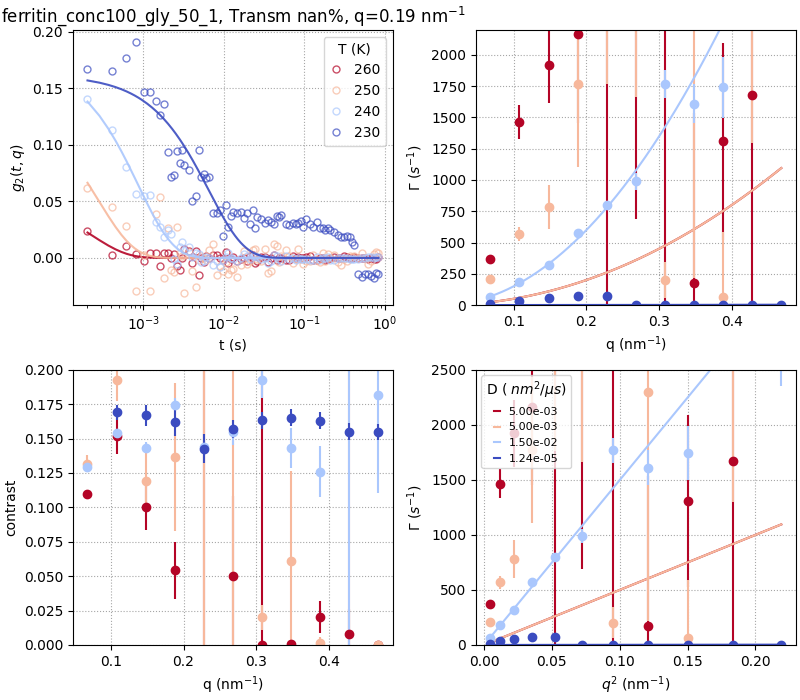

In [45]:
f, ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(8,7), constrained_layout=True)

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))

qv_sel = 4
tol = 1e0
qv_min, qv_max, qstep = 1, len(qv), 1

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    kww, dkww = [], []
    
    for q in range(qv_min, qv_max):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delay, g2s[i,q,:]-base, p0=[beta_vs_q[q],5e-2], 
                                 bounds=[(0,0),(1,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        kww.append(popt[0])
        dkww.append(perr[0])
        
        if q==qv_sel:
            a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7, label=f'{T[i][:-2]}')# ({datasetnumbers[i]})')
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9)#, label=f'{qv[q]:.2f}')
        
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    kww, dkww = np.asarray(kww), np.asarray(dkww)

    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])

    a2.plot(np.sqrt(xc), curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a2.errorbar(qv[qv_min:qv_max], 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a4.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a4.errorbar( qv[qv_min:qv_max]**2, 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a3.errorbar(qv[qv_min:qv_max], kww, dkww, c=col[i], ls='', marker='o', label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')

a1.set_title(f"{runname}, Transm {Tr[i]}%, q={qv[qv_sel]:.2f} nm$^{{-1}}$")
a1.legend(title=r'T (K)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a4.legend(title=r'D ( ${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.5)
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a2.set_xlabel(r'q (nm$^{-1}$)')
a2.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a2.set_ylim(0,2200)
a4.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_ylim(0,2500)
a3.set_xlabel(r'q (nm$^{-1}$)')
a3.set_ylabel('contrast')
a3.set_ylim(0,.2)

# scattering intensity

In [19]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber) in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(delays[i,0])
    # t_exp.append(float(info['Exposure time (s)']))
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

2 0.0002 s
3 0.0002 s
4 0.0002 s
5 0.0002 s
6 0.0002 s
(5, 1000) (1000,)


In [20]:
# water/glycerol
f = np.load("../03-source/backgrounds.npz")
f.files
Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
q_bkg = f['q']
t_exp_bkg = 1e-1

# apoferritin
f = np.load("../03-source/Iqs_apo_conc_gly_50_2_0006.npz")
f.files
Iq_apo = np.average(f['Iqs'],axis=0)
q_apo = f['q']
t_exp_apo = 5e-3

(0.2, 10.0)

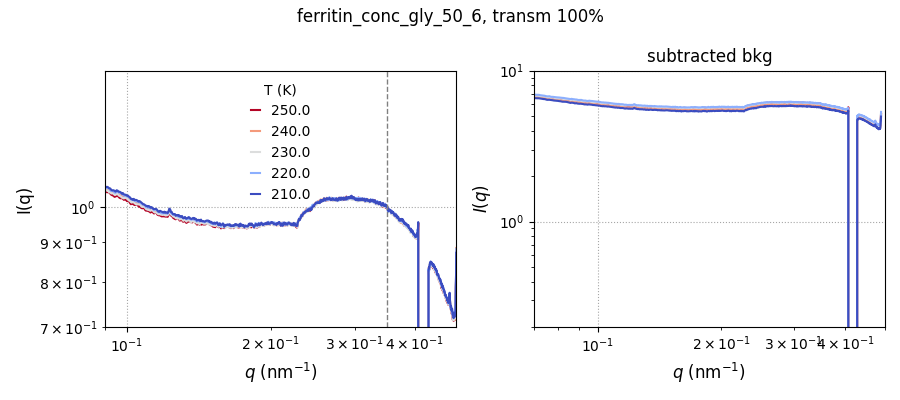

In [31]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))

q_index = 710
# q_index = 5
for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    a1.plot(qI, Iqs[i,:]/Iqs[i,q_index], ls='-', c=col[i], label=f'{T[i]}')
    # a1.plot(qI, Iqs[i,:]/t_exp[i], ls='-', c=col[i], label=f'{T[i][:-2]}')

    # y = Iqs[i,:]-Iq_bkg/t_exp_bkg*t_exp[i]# - Iq_bkg/Iq_bkg[6]*Iqs[i,6]
    y = Iqs[i,:] - Iq_bkg/Iq_bkg[q_index]*Iqs[i,q_index]
    a2.plot(qI, y, c=col[i], ls='-', label=f'{Tr[i]}')
    a2.plot(qI, Iqs[i,:]/t_exp[i], ls='-', c=col[i], label=f'{T[i]}')

# a1.plot(qI, Iq_bkg/t_exp_bkg, ls='--', c='k')
f.suptitle(f'{runnames[0]}, transm {Tr[0]}%')
a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
a1.legend(title='T (K)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
a1.set_xscale('log')
a1.set_yscale('log')
a1.set_xlim(qI[0],qI[-1])
a1.set_xlim(9e-2,qI[-1])
a1.set_ylim(7e-1,1.5e0)
# a1.set_title('no bkg subtracted')
a2.set_title('subtracted bkg')
a2.set_ylabel('$I(q)$', fontsize=12)
a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_xscale('log')
a2.set_yscale('log')
a2.set_xlim(.07,.5)
a2.set_ylim(2e-1,1e1)

# Different concentrations

In [ ]:
runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
datasetnumbers = [] # 240 K

In [ ]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber) in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(delays[i,0])
    # t_exp.append(float(info['Exposure time (s)']))
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))